In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
from PIL import Image # 画像表示用
import matplotlib.pyplot as plt # 画像表示用

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/?", one_hot=True)

Extracting MNIST_data/?/train-images-idx3-ubyte.gz
Extracting MNIST_data/?/train-labels-idx1-ubyte.gz
Extracting MNIST_data/?/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/?/t10k-labels-idx1-ubyte.gz


In [2]:
def var_weight(shape, name):
    return tf.get_variable(name, initializer=tf.truncated_normal(shape))

def var_bias(shape, name):
    return tf.get_variable(name, initializer=tf.constant(0.1, shape=shape))

def conv2d_pool(inputs, filter_shape, name):
    with tf.variable_scope(name):
        flt = var_weight(filter_shape, name="filter")
        bias = var_bias([filter_shape[3]], name="bias")

        conv = tf.nn.conv2d(inputs, flt, [1, 1, 1, 1], padding="SAME") + bias
        relu = tf.nn.relu(conv)
        return tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding="SAME")

def linear(inputs, output_dim, name):
    input_dim = inputs.get_shape()[1].value
    with tf.variable_scope(name):
        weight = var_weight([input_dim, output_dim], "weight")
        bias = var_bias([output_dim], "bias")
        return tf.matmul(inputs, weight) + bias
    
x = tf.placeholder(tf.float32, [None, 28*28])
labels = tf.placeholder(tf.float32, [None, 10])

xb = tf.reshape(x, [-1, 28, 28, 1])
c1 = conv2d_pool(xb, [5, 5, 1, 32], name="conv1")
c2 = conv2d_pool(c1, [5, 5, 32, 32], name="conv2")

c2_flat = tf.reshape(c2, [-1, 7*7*32])

l1 = tf.nn.relu(linear(c2_flat, 1024, "l1"))

keep_prob = tf.placeholder(tf.float32)
relu3_drop = tf.nn.dropout(l1, keep_prob)

l2 = linear(l1, 10, "l2")

top_1 = tf.nn.top_k(l2, k=1)
img = tf.reshape(x, [-1, 28, 28])

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(l2, labels))

opt = tf.train.AdamOptimizer()
opt_op = opt.minimize(loss)



[u'conv1/filter:0', u'conv1/bias:0', u'conv2/filter:0', u'conv2/bias:0', u'l1/weight:0', u'l1/bias:0', u'l2/weight:0', u'l2/bias:0', u'beta1_power:0', u'beta2_power:0', u'conv1/filter/Adam:0', u'conv1/filter/Adam_1:0', u'conv1/bias/Adam:0', u'conv1/bias/Adam_1:0', u'conv2/filter/Adam:0', u'conv2/filter/Adam_1:0', u'conv2/bias/Adam:0', u'conv2/bias/Adam_1:0', u'l1/weight/Adam:0', u'l1/weight/Adam_1:0', u'l1/bias/Adam:0', u'l1/bias/Adam_1:0', u'l2/weight/Adam:0', u'l2/weight/Adam_1:0', u'l2/bias/Adam:0', u'l2/bias/Adam_1:0']
epoch = 0
57230.3


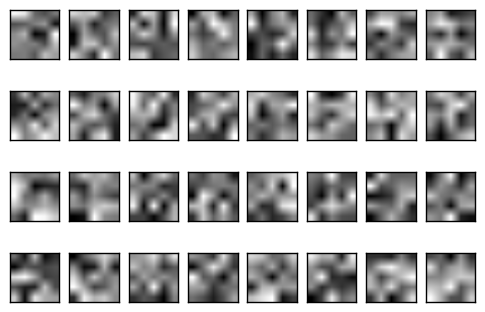

epoch = 100
795.536


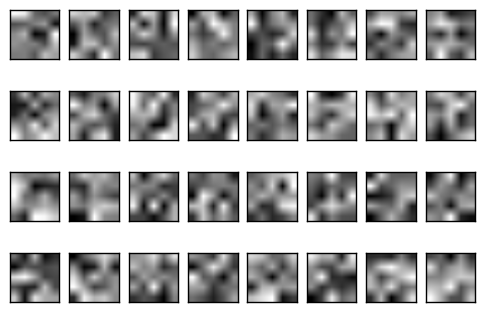

epoch = 200
686.452


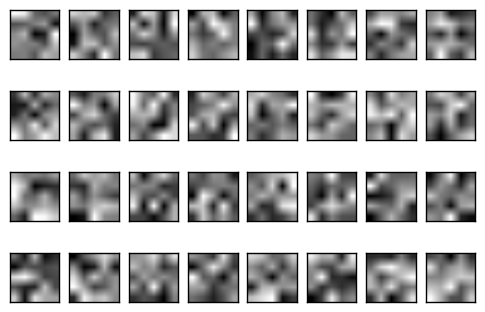

epoch = 300
233.067


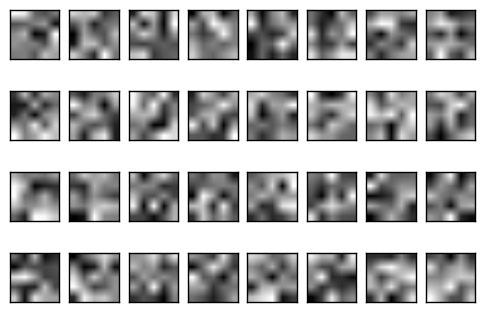

epoch = 400
554.442


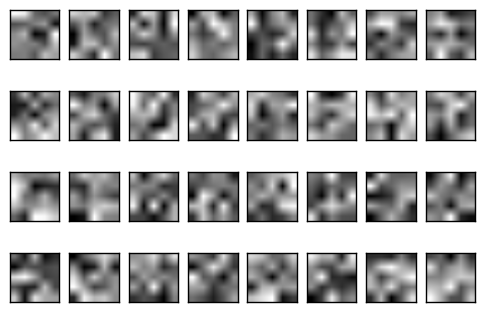

TopKV2(values=array([[ 27735.57226562],
       [ 17734.23828125],
       [ 18539.37890625],
       [ 18700.47851562],
       [ 13495.60742188],
       [ 21900.0390625 ],
       [ 21336.85351562],
       [ 19152.10742188],
       [ 14124.55566406],
       [ 27707.86914062]], dtype=float32), indices=array([[0],
       [6],
       [9],
       [0],
       [1],
       [5],
       [9],
       [7],
       [3],
       [4]], dtype=int32))


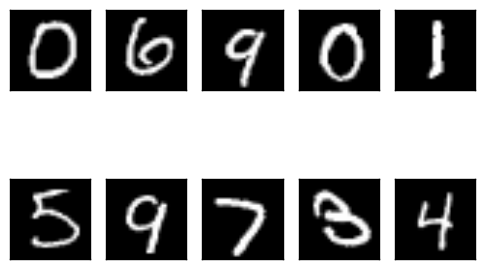

In [4]:
def tick_params():
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        left='off',      # ticks along the bottom edge are off
        right='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off') # labels along the bottom edge are off
    

print(map(lambda e: e.name, tf.global_variables()))
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for ep in range(500):
        
        batch_xs, batch_labels = mnist.train.next_batch(100)
        _loss, _ = sess.run([loss, opt_op], feed_dict={x:batch_xs, labels: batch_labels, keep_prob: 0.5})
        
        if ep % 100 == 0:
            print("epoch = %d" % (ep))
            print(_loss)
            with tf.variable_scope(tf.get_variable_scope(), reuse=True):
                a = np.array(tf.get_variable("conv2/filter").eval())
                a = np.moveaxis(a, -1, 0)
                a = np.reshape(a, [-1, 5, 5])
                fig = plt.figure()
                for i in range(32):
                    fig.add_subplot(4, 8, i+1)
                    tick_params()
                    plt.gray()
                    plt.imshow(a[i])
                
            plt.show()
                
    
    batch_xs, batch_labels = mnist.test.next_batch(10)
    _top_1, _imgs = sess.run([top_1, img], feed_dict={x:batch_xs, labels: batch_labels, keep_prob: 1.})
    print(_top_1)
    fig = plt.figure()
    for i in range(10):
        fig.add_subplot(2, 5, i+1)
        tick_params()
        plt.imshow(_imgs[i])
        plt.gray()
    
    plt.show()